In [99]:
# Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

Pull in Stock Data

In [100]:
# TODO: enter your ETF ticker, dates, and price interval
# set parameters for data pull
ticker = 'IWV'

# access data and display
df_etf = yf.download(ticker, interval='1d', period='max')

# Calculate daily returns [(new / old) - 1]
df_etf['ret'] = ((df_etf['Adj Close'] / df_etf['Adj Close'].shift()) - 1) * 100
df_etf = df_etf.reindex(columns=['Adj Close', 'ret'])

[*********************100%%**********************]  1 of 1 completed


Pull in Risk Free, FOMC Dates, Federal Funds Target Rate

In [101]:
# Pull in Fama/French 3 Factors [Daily] csv file
df_rf = pd.read_csv('RF.csv', skiprows=3, index_col=0, skipfooter=1)
df_rf.index = pd.to_datetime(df_rf.index, format='%Y%m%d', errors='coerce')
df_rf['RF'] /= 100

# Merge risk-free rate and etf data 
df_all = pd.merge(df_rf, df_etf, left_index=True, right_index=True, how='inner').dropna()
df_all.drop(['Mkt-RF', 'SMB', 'HML'], axis=1, inplace=True)

# Calculate excess returns
df_all['xs_ret'] = df_all['ret'] - df_all['RF']

# Pull in provided fomc data
df_fomc = pd.read_csv('FOMC_DATES.csv', index_col='Date')

# Reformat dates
df_fomc.index = pd.to_datetime(df_fomc.index, format='%Y%m%d', errors='coerce')

# Merge fomc dates
df_all = pd.merge(df_all, df_fomc, left_index=True, right_index=True, how='left')
df_all['fomc'] = df_all['fomc'].fillna(0)

# Reset index and make date column
df_all.index.name = 'Date'

# Pull Federal Funds Rate
df_ir = pd.read_csv('DFEDTAR.csv')
df_ir['Date'] = pd.to_datetime(df_ir['Date'])
df_ir.set_index('Date', inplace=True)

# Manipulate Federal Funds Rate
df_ir = df_ir.rename(columns={'interest rate': 'rate_after'})
df_ir['rate_before'] = df_ir['rate_after'].shift(1)
conditions = [
    (df_ir['rate_after'] > df_ir['rate_before']),
    (df_ir['rate_after'] < df_ir['rate_before']),
    (df_ir['rate_after'] == df_ir['rate_before'])
]
actions = ['raise', 'lower', 'nothing']
df_ir['action'] = np.select(conditions, actions, default='unknown')
df_all = pd.merge(df_all, df_ir, left_index=True, right_index=True, how='left')

# Pull VIX
df_vix = pd.read_csv('VIX.csv')
df_vix['Date'] = pd.to_datetime(df_vix['Date'])
df_vix.set_index('Date', inplace=True)
df_vix = df_vix.rename(columns={'Adj Close': 'VIX Adj Close'})
df_vix = df_vix.reindex(['VIX Adj Close'], axis=1)
df_vix['VIX Change'] = ((df_vix['VIX Adj Close'] / df_vix['VIX Adj Close'].shift()) - 1) * 100
df_all = pd.merge(df_all, df_vix, left_index=True, right_index=True, how='left')

df_all


C:\Users\andre\AppData\Local\Temp\ipykernel_8536\1978636867.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_rf = pd.read_csv('RF.csv', skiprows=3, index_col=0, skipfooter=1)


,RF,Adj Close,ret,xs_ret,fomc,rate_after,rate_before,action,VIX Adj Close,VIX Change
Date,,,,,,,,,,
2000-05-30,0.00023,52.222107,2.864325,2.864095,0.0,6.50,6.50,nothing,23.620001,NaN
2000-05-31,0.00023,52.780552,1.069365,1.069135,0.0,6.50,6.50,nothing,23.650000,0.127007
2000-06-01,0.00018,52.928082,0.279515,0.279335,0.0,6.50,6.50,nothing,22.360001,-5.454541
2000-06-02,0.00018,54.614025,3.185348,3.185168,0.0,6.50,6.50,nothing,21.480000,-3.935604
2000-06-05,0.00018,54.329494,-0.520985,-0.521165,0.0,6.50,6.50,nothing,22.709999,5.726252
...,...,...,...,...,...,...,...,...,...,...
2023-07-25,0.00022,260.756927,0.233537,0.233317,0.0,5.25,5.25,nothing,13.860000,-0.359454
2023-07-26,0.00022,260.995941,0.091661,0.091441,1.0,5.25,5.25,nothing,13.190000,-4.834055
2023-07-27,0.00022,259.073761,-0.736479,-0.736699,0.0,5.50,5.25,raise,14.410000,9.249431


In [102]:
# replot of buy date vs sell date with bubbles being the size of the return

#INPUTS

buy_day = -4
sell_day = 14

In [103]:
# Set buy date and sell date
df_all['buy'] = df_all['fomc'].shift(buy_day)
df_all['sell'] = df_all['fomc'].shift(sell_day)
df_all

,RF,Adj Close,ret,xs_ret,fomc,rate_after,rate_before,action,VIX Adj Close,VIX Change,buy,sell
Date,,,,,,,,,,,,
2000-05-30,0.00023,52.222107,2.864325,2.864095,0.0,6.50,6.50,nothing,23.620001,NaN,0.0,NaN
2000-05-31,0.00023,52.780552,1.069365,1.069135,0.0,6.50,6.50,nothing,23.650000,0.127007,0.0,NaN
2000-06-01,0.00018,52.928082,0.279515,0.279335,0.0,6.50,6.50,nothing,22.360001,-5.454541,0.0,NaN
2000-06-02,0.00018,54.614025,3.185348,3.185168,0.0,6.50,6.50,nothing,21.480000,-3.935604,0.0,NaN
2000-06-05,0.00018,54.329494,-0.520985,-0.521165,0.0,6.50,6.50,nothing,22.709999,5.726252,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25,0.00022,260.756927,0.233537,0.233317,0.0,5.25,5.25,nothing,13.860000,-0.359454,0.0,0.0
2023-07-26,0.00022,260.995941,0.091661,0.091441,1.0,5.25,5.25,nothing,13.190000,-4.834055,NaN,0.0
2023-07-27,0.00022,259.073761,-0.736479,-0.736699,0.0,5.50,5.25,raise,14.410000,9.249431,NaN,0.0


In [104]:
# Calculate Sharpe Ratio
num_days = abs(buy_day - sell_day)
scale = num_days * 8

df_result = df_all.query('sell == 1 or buy == 1')
df_result['buy_price'] = df_result['Adj Close'].shift(1)
df_result['strat_ret'] = (df_result['Adj Close'] / df_result['buy_price']) - 1
df_result['strat_xs_ret'] = df_result['strat_ret'] - df_result['RF']

mean = df_result['strat_xs_ret'].mean() 
stdev = df_result['strat_xs_ret'].std()

sharpe = (mean / stdev)  #* np.sqrt(scale) # Not scaled currently
df_result

C:\Users\andre\AppData\Local\Temp\ipykernel_8536\632222725.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['buy_price'] = df_result['Adj Close'].shift(1)
C:\Users\andre\AppData\Local\Temp\ipykernel_8536\632222725.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['strat_ret'] = (df_result['Adj Close'] / df_result['buy_price']) - 1
C:\Users\andre\AppData\Local\Temp\ipykernel_8536\632222725.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,RF,Adj Close,ret,xs_ret,fomc,rate_after,rate_before,action,VIX Adj Close,VIX Change,buy,sell,buy_price,strat_ret,strat_xs_ret
Date,,,,,,,,,,,,,,,
2000-06-22,0.00018,53.990566,-1.291634,-1.291814,0.0,6.50,6.50,nothing,22.000000,6.744294,1.0,0.0,NaN,NaN,NaN
2000-07-19,0.00024,54.918526,-1.251402,-1.251642,0.0,6.50,6.50,nothing,19.650000,-0.506329,0.0,1.0,53.990566,0.017187,0.016947
2000-08-16,0.00022,54.644363,-0.346135,-0.346355,0.0,6.50,6.50,nothing,18.020000,0.222469,1.0,0.0,54.918526,-0.004992,-0.005212
2000-09-12,0.00025,55.551231,-0.113739,-0.113989,0.0,6.50,6.50,nothing,18.590000,1.032609,0.0,1.0,54.644363,0.016596,0.016346
2000-11-09,0.00024,52.230343,-0.921815,-0.922055,0.0,6.50,6.50,nothing,27.200001,6.001563,1.0,0.0,55.551231,-0.059781,-0.060021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-27,0.00018,234.453766,1.925979,1.925799,0.0,5.00,5.00,nothing,17.030001,-9.607213,1.0,0.0,232.596252,0.007986,0.007806
2023-05-23,0.00016,235.854355,-1.041922,-1.042082,0.0,5.25,5.25,nothing,18.530001,7.669971,0.0,1.0,234.453766,0.005974,0.005814
2023-06-08,0.00019,244.801956,0.461847,0.461657,0.0,5.25,5.25,nothing,13.650000,-2.080344,1.0,0.0,235.854355,0.037937,0.037747


0.004739334469388837
0.03784676295503546
0.1252243018780626


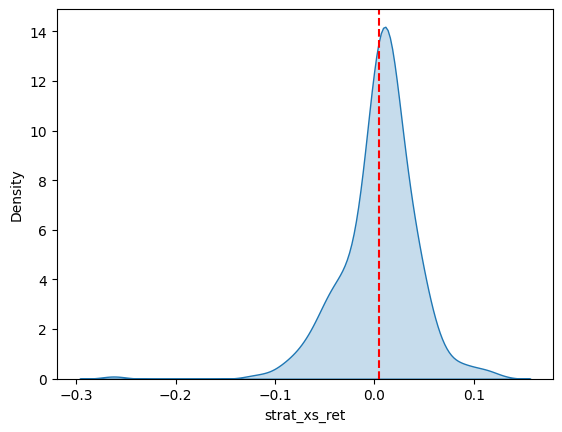

In [105]:
sns.kdeplot(data=df_result, x='strat_xs_ret', fill=True)
plt.axvline(x=mean, color='red', linestyle='--')
print(mean)
print(stdev)
print(sharpe)

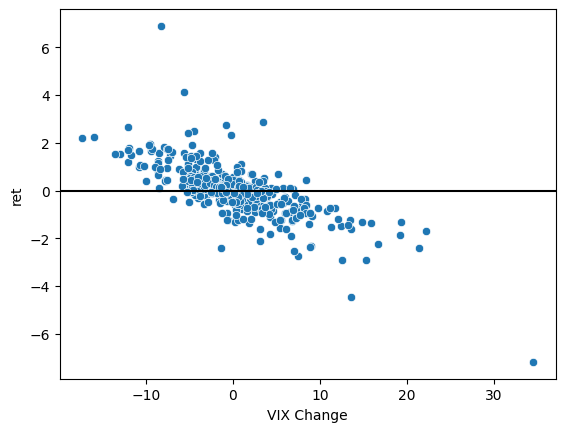

In [107]:
sns.scatterplot(data=df_result, y = 'ret', x = 'VIX Change')
plt.axhline(y = 0, color = 'black')
